In [1]:
import sys
sys.path.append("..")

from data_utils import SCPDataSet, stratified_split
from data_utils import Sm2Smiles, Smiles2Mol, Mol2Morgan, Type2OneHot
from train import train, loss_fn
from model import *

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader

from sklearn.model_selection import KFold

import pandas as pd

In [2]:
de_train = pd.read_parquet("../data/de_train.parquet")

In [3]:
import os
os.chdir("..")

In [4]:
sm_smiles_df = pd.read_csv("config/sm_smiles.csv")
sm_smiles_dict = sm_smiles_df.set_index("sm_name").to_dict()["SMILES"]
ctypes = de_train['cell_type'].unique()
mtypes = de_train['sm_name'].unique()

In [39]:
cell_types = list(de_train["cell_type"])
kfold = KFold(n_splits=5, shuffle=True, random_state=983)

# train_index, val_index = stratified_split(cell_types, 0.25, 194)

val_all_list, train_all_list = [], []
for fold, (train_index, val_index) in enumerate(kfold.split(de_train)):
    train_df = de_train.iloc[train_index]
    val_df = de_train.iloc[val_index]

    train_dataset = SCPDataSet(train_df)
    val_dataset = SCPDataSet(val_df)
    train_dataloader = DataLoader(train_dataset, 264)
    val_dataloader = DataLoader(val_dataset, 264)

    mol_enc_size, cell_enc_size = 20, 4
    model = CombinerModel(
        mol_encoder=VecEncoder([len(mtypes)]),
        cell_encoder=VecEncoder([len(ctypes)]),
        regressor=VecEncoder([len(mtypes)+len(ctypes), 
                            50, 50, len(de_train.columns)-5])
    )

    train_all, val_all = [], []

    args = {
        "lr": [0.001],
        "epochs": [100],
        "mol_transform": [Type2OneHot(mtypes)],
        "cell_transform": [Type2OneHot(ctypes)]
    }

    for lr, epochs in zip(args["lr"], args["epochs"]):
        args_in = args.copy()
        args_in["lr"], args_in["epochs"] = lr, epochs
        optimizer = Adam(model.parameters(), lr=args_in["lr"], weight_decay=1e-4)
        train_loss, val_loss = train(train_dataloader, val_dataloader, model, args_in, loss_fn, optimizer)
        train_all.append(train_loss)
        val_all.append(val_loss)

    train_all_list.append(train_all)
    val_all_list.append(val_all)

cuda:0


100%|██████████| 100/100 [00:09<00:00, 10.44it/s]


cuda:0


100%|██████████| 100/100 [00:09<00:00, 11.09it/s]


cuda:0


100%|██████████| 100/100 [00:09<00:00, 10.89it/s]


cuda:0


100%|██████████| 100/100 [00:09<00:00, 10.93it/s]


cuda:0


100%|██████████| 100/100 [00:08<00:00, 11.80it/s]


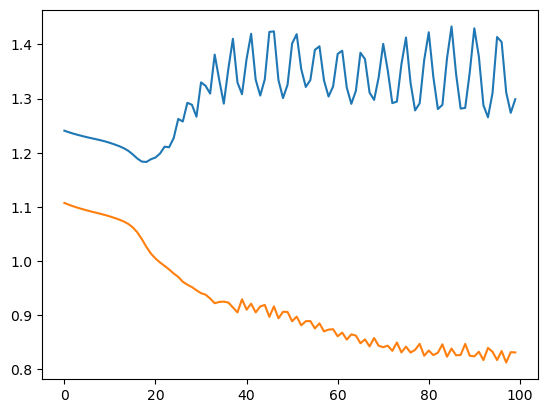

In [42]:
import matplotlib.pyplot as plt

plt.plot(sum(val_all_list[2], []))
plt.plot(sum(train_all_list[2], []))